Reference:

Hierarchical community detection by recursive partitioning

https://arxiv.org/pdf/1810.01509.pdf

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import matrix_power

In [2]:
meetings_meaningful_all = pd.read_csv('meetings_meaningful_all.csv')
meetings_meaningful_all

,Source,Target,Weight,Internal1,Internal2
0,1,6,18,False,True
1,1,7,13,False,True
2,1,9,16,False,True
3,1,14,31,False,True
4,1,15,30,False,False
...,...,...,...,...,...
4315,1684,1686,1,True,True
4316,1684,1689,3,True,True
4317,1685,1689,5,True,True
4318,1723,1763,1,False,False


In [3]:
df = meetings_meaningful_all[meetings_meaningful_all['Internal1'] & meetings_meaningful_all['Internal2']].reset_index(drop=True)
df = df[['Source', 'Target', 'Weight']]
df

,Source,Target,Weight
0,1,44,5
1,1,48,1
2,1,49,1
3,1,60,1
4,1,61,2
...,...,...,...
3019,1684,1685,3
3020,1684,1686,1
3021,1684,1689,3
3022,1685,1689,5


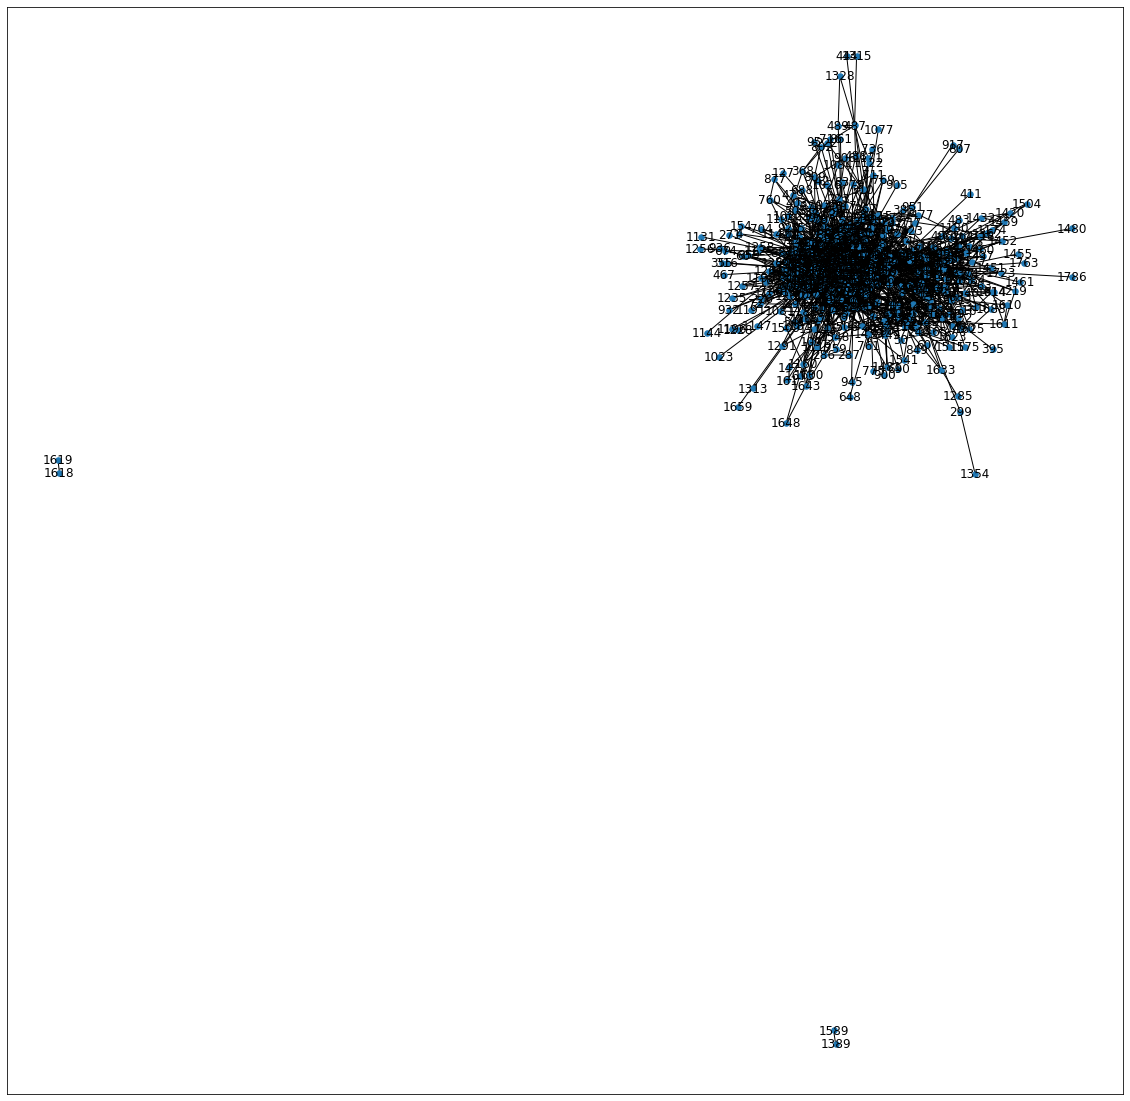

In [4]:
orig_G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr = 'Weight')
plt.figure(figsize = (20,20))
pos = nx.spring_layout(orig_G)

nx.draw_networkx(orig_G, pos, node_size = 30);


In [5]:
nodes = list(set(df['Source'].append(df['Target'])))
print('Number of distinct nodes in this network: ', len(nodes))

Number of distinct nodes in this network:  473


In [6]:
#Create a dictionary showing the index corresponds to each node_id
idx_vs_node_id = {k: v for v, k in enumerate(nodes)} #{1: 0, 4: 1, 6: 2, ...}

In [7]:
#Create the adjacency matrix
adj_mat = np.zeros((len(nodes), len(nodes)))

for r in range(len(df)):
    i = df.iloc[r]['Source']
    i = idx_vs_node_id[i]
    j = df.iloc[r]['Target']
    j = idx_vs_node_id[j]
    adj_mat[i][j] = 1
    adj_mat[j][i] = 1
    

In [8]:
adj_mat #A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [9]:
#Algorithm 1

def first_two_eigen_valandvec(A):
    '''
    Return largest_eigenval in magnitude, largest_eigenvec,
    sec_largest_eigenval in magnitude, sec_largest_eigenvec
    '''
    w, v = np.linalg.eig(A) #eigenvalues and vectors
    w_abs = abs(w)

    largest_eigenval = w[0]; largest_idx = 0
    sec_largest_eigenval = w[1]; sec_largest_idx = 1
    if w_abs[1] > w_abs[0]:
        largest_eigenval = w[1]; largest_idx = 1
        sec_largest_eigenval = w[0]; sec_largest_idx = 0
    for i in np.arange(2, len(w)):
        if w_abs[i] > largest_eigenval:
            sec_largest_eigenval = largest_eigenval; sec_largest_idx = largest_idx;
            largest_eigenval = w[i]; largest_idx = i
        if largest_eigenval > w_abs[i] > sec_largest_eigenval:
            sec_largest_eigenval = w[i]; sec_largest_idx = i
    
    largest_eigenvec = v[largest_idx]
    sec_largest_eigenvec = v[sec_largest_idx]
    return largest_eigenval, largest_eigenvec, sec_largest_eigenval, sec_largest_eigenvec

def HCD_algo1_helper(A):
    '''
    The helper function of HCD_algo1
    Returns label_c
    '''
    #1. Compute the eigenvector corresponding to the second largest eigenvalue in magnitude of A.       
    _, _, sec_largest_eigenval, sec_largest_eigenvec = first_two_eigen_valandvec(A)

    #v_sec = v[sec_largest_idx]
    #print("The second largest eigenvalue in magnitude is {} with eigenvector {} (only first few elements are shown))".format(sec_largest_eigenval, sec_largest_eigenvec[0:3]))

    #2. Compute label_c that splits nodes into two groups
    label_c = sec_largest_eigenvec < 0
    return label_c


def HCD_algo1(A, A_nodes):
    '''
    This is a hierarchical clustering detection algorithm.
    A: The adjacency matrix of the target network.
    This function returns an array of strings, consisting of 0s and 1s.
    Each string indicates a community.
    '''
    label_c = HCD_algo1_helper(np.asarray(A))
    result_dict = {k: str(int(0 or label_c[v])) for v, k in enumerate(A_nodes)} #{1: 0 or 1, 4: 0 or 1, 6: 0 or 1, ...} 
    
    return label_c, result_dict

In [10]:
c, _ = HCD_algo1(adj_mat, nodes)
c

array([False,  True, False, False, False, False,  True,  True,  True,
        True, False, False,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True, False,  True,  True, False, False,  True, False,
        True,  True, False,  True, False,  True,  True, False,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False, False, False, False,
        True, False,  True,  True,  True, False,  True, False,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True, False, False,  True,  True, False,
        True, False,  True, False, False,  True, False, False,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False,  True,

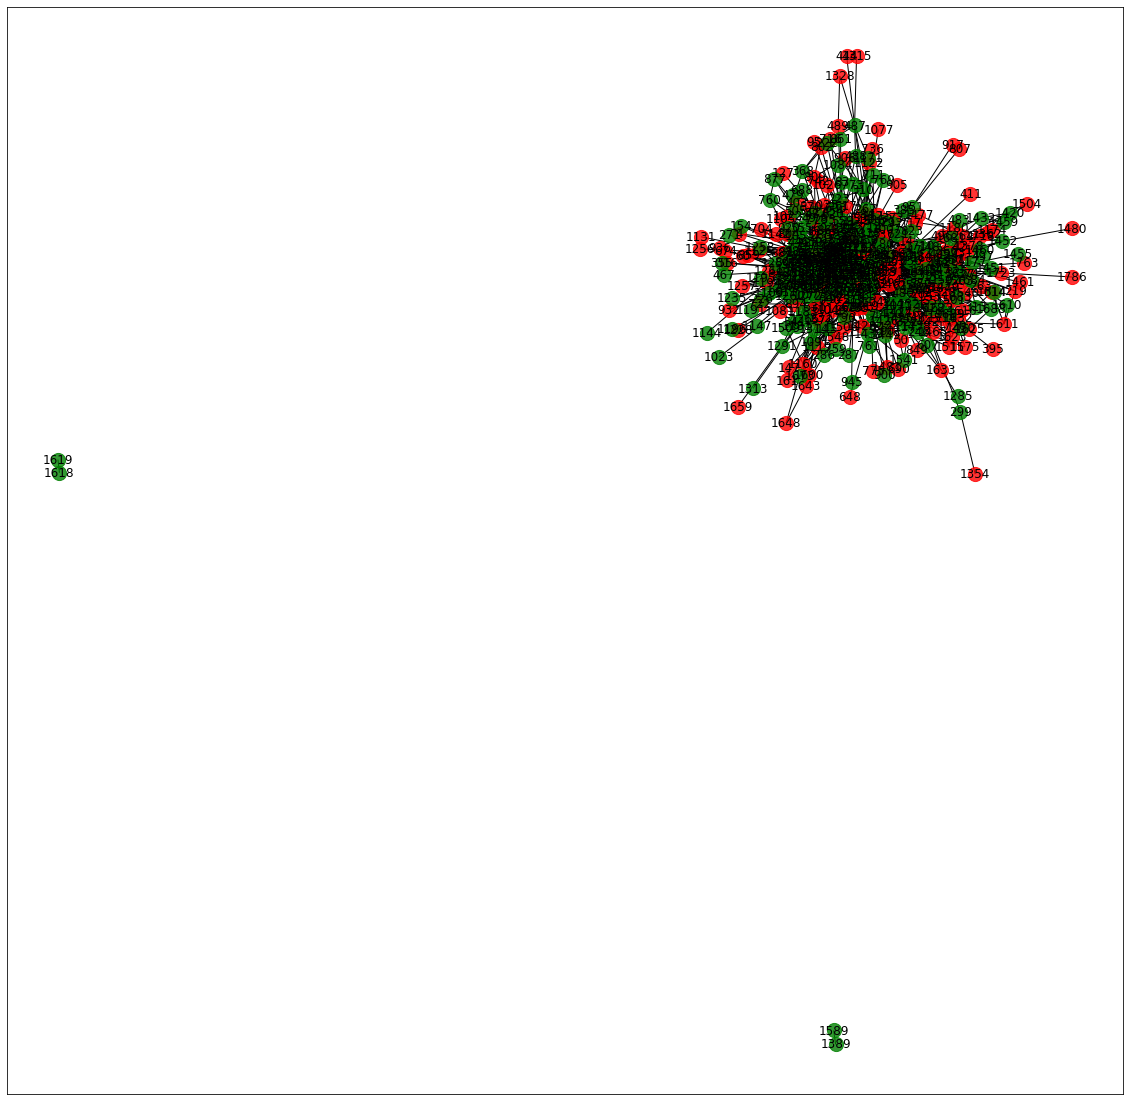

In [11]:
plt.figure(figsize = (20,20))
options = {"node_size": 200, "alpha": 0.8}

#pos = nx.spring_layout(orig_G, k = 0.01)
nx.draw_networkx_nodes(orig_G, pos, nodelist=[x for x, y in zip(nodes, c) if y], node_color='r', **options)
nx.draw_networkx_nodes(orig_G, pos, nodelist=[x for x, y in zip(nodes, c) if not y], node_color='g', **options)

nx.draw_networkx_edges(orig_G, pos);
nx.draw_networkx_labels(orig_G, pos);

In [13]:
#Algorithm 2

def get_L_tau(A, G, tau=0.1):
    d_bar = sum(dict(G.degree()).values())/len(G.nodes)
    A_tau = A + np.full(A.shape, tau * d_bar / len(nodes))
    
    d_tau = A_tau.sum(axis=0)
    D_tau = np.zeros(A.shape)
    np.fill_diagonal(D_tau, d_tau**(-1/2))
    
    L_tau = D_tau * A_tau * D_tau
    return L_tau

def HCD_algo2(A, G, tau=0.1):
    L_tau = get_L_tau(A, G, tau)
    _, L_tau_largest_eigenvec, _, L_tau_sec_largest_eigenvec = first_two_eigen_valandvec(L_tau)
    return L_tau_largest_eigenvec, L_tau_sec_largest_eigenvec

In [14]:
HCD_algo2(adj_mat, orig_G, 0)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [12]:
def get_nonbt_mat(A):    
    d = A.sum(axis=0)
    D = np.zeros(A.shape)
    np.fill_diagonal(D, d)
    
    B = np.zeros(A.shape)
    I = np.zeros(A.shape)
    np.fill_diagonal(I, -1)
    
    B = np.concatenate((B, I), axis=0) #Left half of B_np
    tmp = np.concatenate((D-I, A), axis=0) #Right half of B_np
    B = np.concatenate((B, tmp), axis=1)
    
    return B

def nonbt_norm_approx(G):
    deg_list = list(dict(G.degree()).values())
    return np.sum(np.square(deg_list)) / np.sum(deg_list) - 1

In [16]:
B_nb = get_nonbt_mat(adj_mat)
eigval1, _, eigval2, _ = first_two_eigen_valandvec(B_nb)

In [17]:
eigval1.real, eigval2.real

(24.264875287248586, 12.841997086300744)

In [18]:
np.sqrt(nonbt_norm_approx(orig_G))

4.6883001962501005

In [13]:
def stopping_rule(A, G):
    '''
    Stop if returns True.
    '''
    B_nb = get_nonbt_mat(A)
    eigval1, _, eigval2, _ = first_two_eigen_valandvec(B_nb)
    threshold = np.sqrt(nonbt_norm_approx(orig_G))
    return not ((eigval1.real > threshold) & (eigval2.real > threshold))

In [20]:
stopping_rule(adj_mat, orig_G)

False

In [66]:
d

{1: '0',
 4: '1',
 6: '0',
 7: '0',
 9: '0',
 10: '0',
 14: '1',
 15: '1',
 17: '1',
 22: '1',
 33: '0',
 35: '0',
 41: '1',
 42: '1',
 44: '0',
 45: '1',
 48: '1',
 49: '0',
 50: '1',
 55: '1',
 60: '1',
 61: '1',
 63: '1',
 64: '0',
 82: '1',
 83: '0',
 89: '0',
 90: '1',
 95: '1',
 109: '0',
 112: '1',
 113: '1',
 114: '0',
 115: '0',
 116: '1',
 117: '0',
 119: '1',
 123: '1',
 124: '0',
 127: '1',
 128: '0',
 135: '1',
 142: '1',
 145: '0',
 147: '1',
 150: '0',
 152: '1',
 154: '0',
 161: '1',
 184: '1',
 192: '1',
 197: '0',
 204: '1',
 219: '1',
 222: '0',
 223: '0',
 226: '0',
 227: '1',
 232: '1',
 246: '0',
 250: '0',
 256: '0',
 257: '0',
 258: '1',
 259: '0',
 263: '1',
 264: '1',
 266: '1',
 267: '0',
 268: '1',
 271: '0',
 277: '1',
 283: '1',
 285: '1',
 286: '0',
 287: '0',
 295: '0',
 299: '0',
 308: '1',
 309: '1',
 310: '0',
 313: '0',
 314: '0',
 316: '1',
 317: '1',
 322: '0',
 325: '0',
 328: '1',
 341: '1',
 344: '0',
 346: '1',
 347: '0',
 353: '1',
 355: '0',


In [14]:
#Algo1 + Stopping rule

def sub_network(A, G):
    G_nodes = list(G.nodes)
    G_nodes.sort()
    c, d = HCD_algo1(A, G_nodes)
    
    subnodes1 = np.array(G_nodes)[list(c)]
    #subedges1 = G.edges(subnodes1)
    subnodes2 = np.array(G_nodes)[list(~c)]
    #subedges2 = G.edges(subnodes2)
    
    #subG1 = G.subgraph(subnodes1)
    #subG2 = G.subgraph(subnodes2)
    return subnodes1, subnodes2, d

def hierarchical_clustering(A, G, d):
    if stopping_rule(A, G):
        return A, G, d

    subnodes1, subnodes2, res_d = sub_network(A, G)
    for key in res_d:
        d[key] = d[key] + res_d[key]

    subA1 = nx.to_numpy_matrix(G, nodelist = subnodes1)
    subA2 = nx.to_numpy_matrix(G, nodelist = subnodes2)
    #print(d)
    #left tree
    _, _, d = hierarchical_clustering(subA1, G.subgraph(subnodes1), d)
    #right tree
    _, _, d = hierarchical_clustering(subA2, G.subgraph(subnodes2), d)
    
    return A, G, d

In [41]:
empty_d = {k: '' for k in nodes}

_, _, result_d = hierarchical_clustering(adj_mat, orig_G, empty_d)

In [42]:
result_d

{1: '00',
 4: '10',
 6: '00',
 7: '01',
 9: '01',
 10: '01',
 14: '10',
 15: '10',
 17: '11',
 22: '11',
 33: '01',
 35: '00',
 41: '11',
 42: '10',
 44: '00',
 45: '10',
 48: '10',
 49: '01',
 50: '10',
 55: '10',
 60: '10',
 61: '10',
 63: '11',
 64: '00',
 82: '11',
 83: '01',
 89: '00',
 90: '11',
 95: '10',
 109: '00',
 112: '10',
 113: '11',
 114: '00',
 115: '01',
 116: '10',
 117: '00',
 119: '10',
 123: '10',
 124: '01',
 127: '10',
 128: '00',
 135: '11',
 142: '10',
 145: '00',
 147: '11',
 150: '00',
 152: '11',
 154: '01',
 161: '10',
 184: '11',
 192: '10',
 197: '00',
 204: '10',
 219: '11',
 222: '00',
 223: '00',
 226: '01',
 227: '10',
 232: '11',
 246: '01',
 250: '01',
 256: '00',
 257: '00',
 258: '10',
 259: '01',
 263: '10',
 264: '11',
 266: '11',
 267: '00',
 268: '10',
 271: '00',
 277: '11',
 283: '10',
 285: '10',
 286: '01',
 287: '00',
 295: '00',
 299: '00',
 308: '11',
 309: '11',
 310: '00',
 313: '00',
 314: '01',
 316: '11',
 317: '10',
 322: '00',
 3

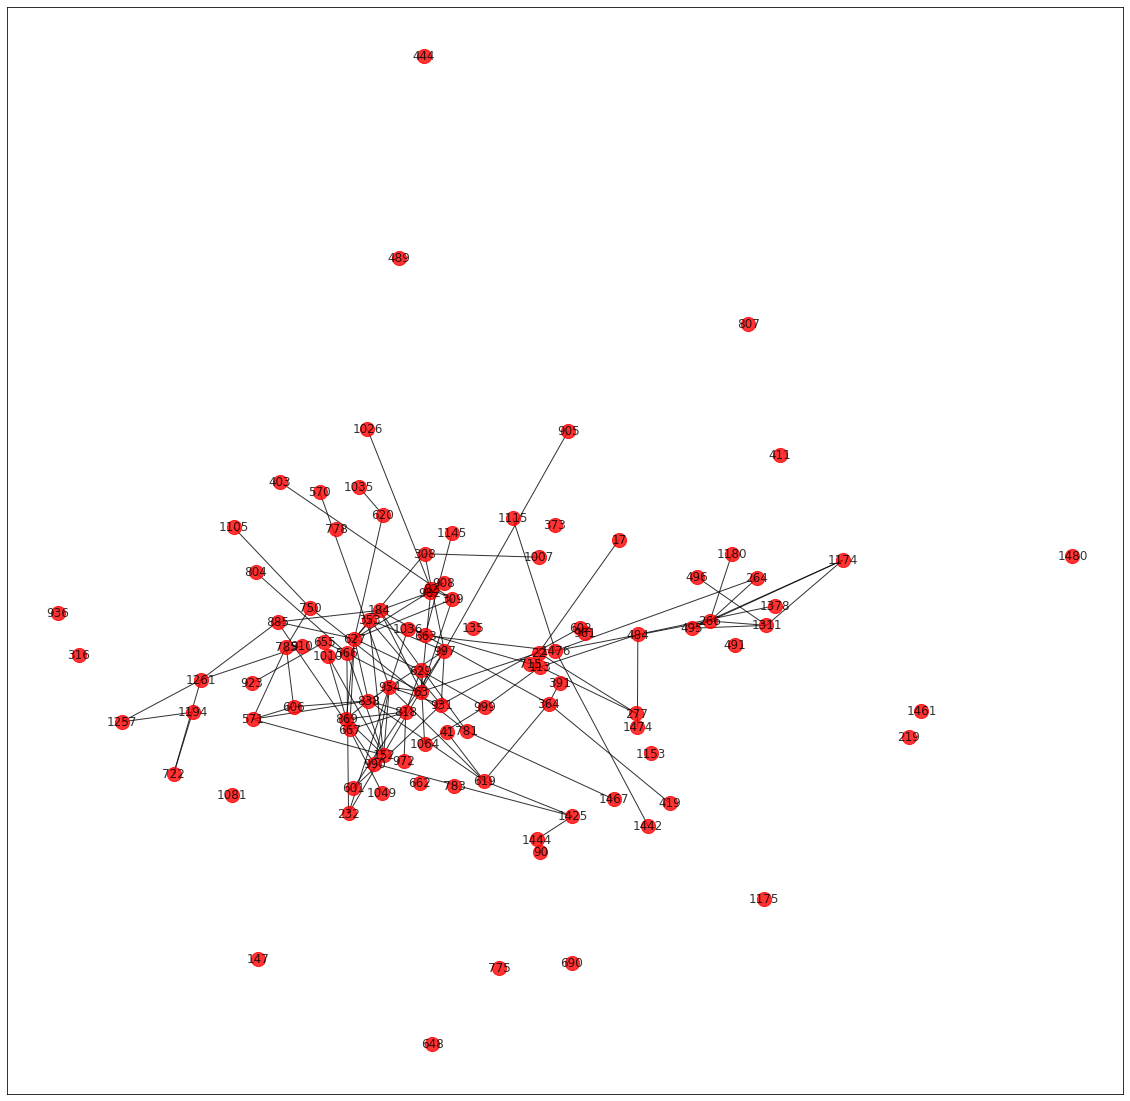

In [27]:
plt.figure(figsize = (20,20))
options = {"node_size": 200, "alpha": 0.8}

#pos = nx.spring_layout(orig_G, k = 0.01)
nx.draw_networkx(orig_G.subgraph(subnodes1a), pos, node_color='r', **options)


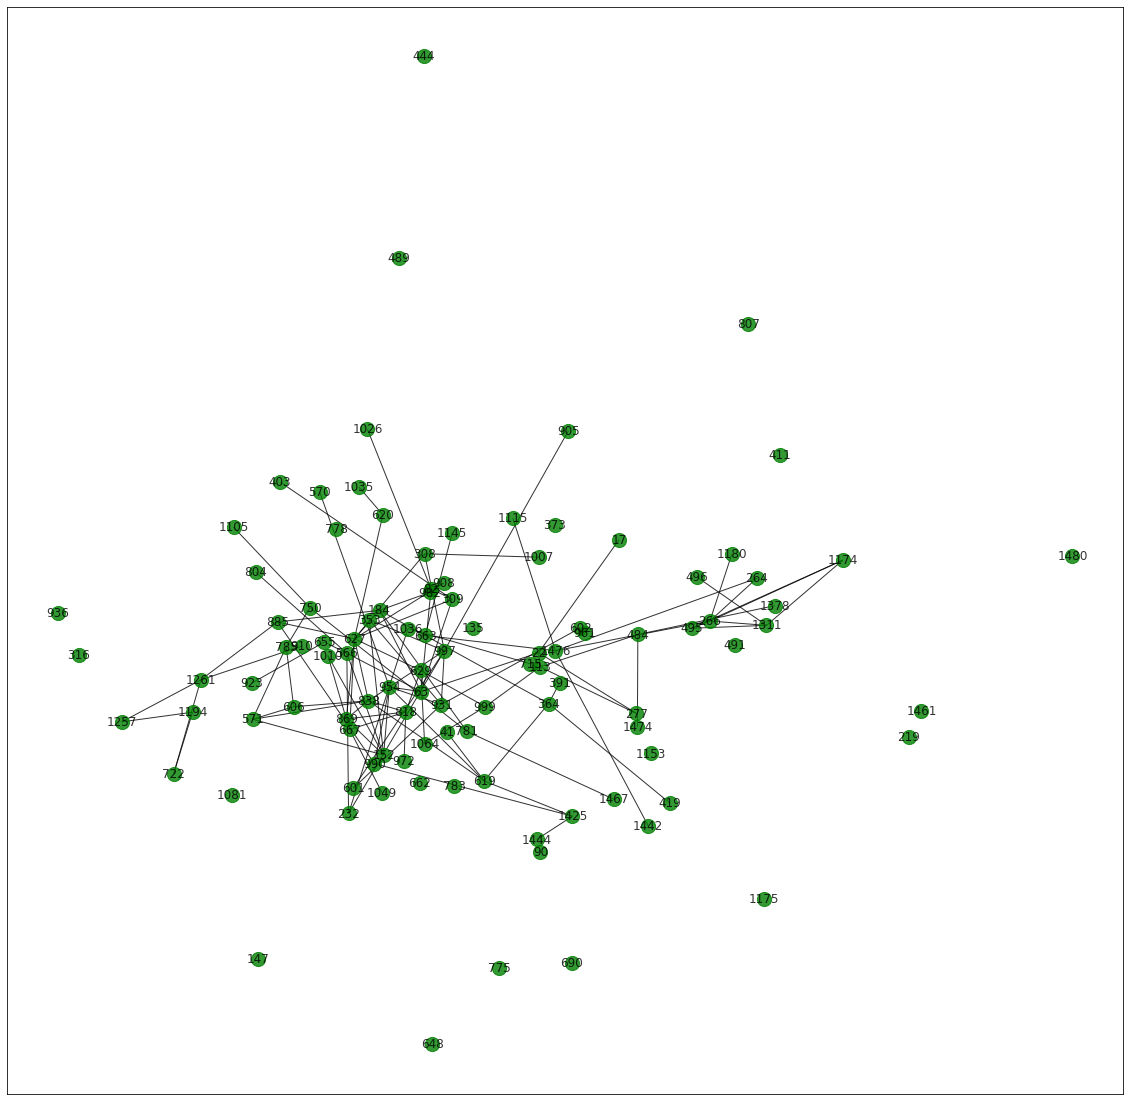

In [29]:
plt.figure(figsize = (20,20))
options = {"node_size": 200, "alpha": 0.8}

nx.draw_networkx(orig_G.subgraph(subnodes1).subgraph(subnodes1a), pos, node_color='g', **options)


In [40]:
#sub_network(subA1, orig_G.subgraph(subnodes1))

G_nodes = list(orig_G.subgraph(subnodes1).nodes)
G_nodes.sort()
HCD_algo1(subA1, G_nodes)


(array([False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False,  True,  True,  True, False, False,
         True, False, False, False, False,  True, False,  True,  True,
        False,  True, False, False,  True, False,  True, False, False,
         True,  True, False,  True, False, False,  True,  True,  True,
        False, False, False, False,  True,  True, False,  True, False,
         True, False,  True,  True, False,  True, False, False,  True,
        False,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True, False, False, False,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,
         True, False, False, False,  True, False, False,  True, False,
         True, False, False, False, False,  True, False, False, False,
         True,  True, False,  True,  True,  True, False, False,  True,
        False,  True, False,  True, False, False,  True, False, False,
      

In [72]:
nx.to_numpy_matrix(orig_G, nodelist = [1,4,44])

matrix([[0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.]])

In [68]:
empty_d = {k: '' for k in nodes}

{1: '',
 4: '',
 6: '',
 7: '',
 9: '',
 10: '',
 14: '',
 15: '',
 17: '',
 22: '',
 33: '',
 35: '',
 41: '',
 42: '',
 44: '',
 45: '',
 48: '',
 49: '',
 50: '',
 55: '',
 60: '',
 61: '',
 63: '',
 64: '',
 82: '',
 83: '',
 89: '',
 90: '',
 95: '',
 109: '',
 112: '',
 113: '',
 114: '',
 115: '',
 116: '',
 117: '',
 119: '',
 123: '',
 124: '',
 127: '',
 128: '',
 135: '',
 142: '',
 145: '',
 147: '',
 150: '',
 152: '',
 154: '',
 161: '',
 184: '',
 192: '',
 197: '',
 204: '',
 219: '',
 222: '',
 223: '',
 226: '',
 227: '',
 232: '',
 246: '',
 250: '',
 256: '',
 257: '',
 258: '',
 259: '',
 263: '',
 264: '',
 266: '',
 267: '',
 268: '',
 271: '',
 277: '',
 283: '',
 285: '',
 286: '',
 287: '',
 295: '',
 299: '',
 308: '',
 309: '',
 310: '',
 313: '',
 314: '',
 316: '',
 317: '',
 322: '',
 325: '',
 328: '',
 341: '',
 344: '',
 346: '',
 347: '',
 353: '',
 355: '',
 363: '',
 364: '',
 366: '',
 368: '',
 372: '',
 373: '',
 374: '',
 381: '',
 385: '',
 388

In [64]:
tmp1, tmp2 = sub_network(adj_mat, orig_G)

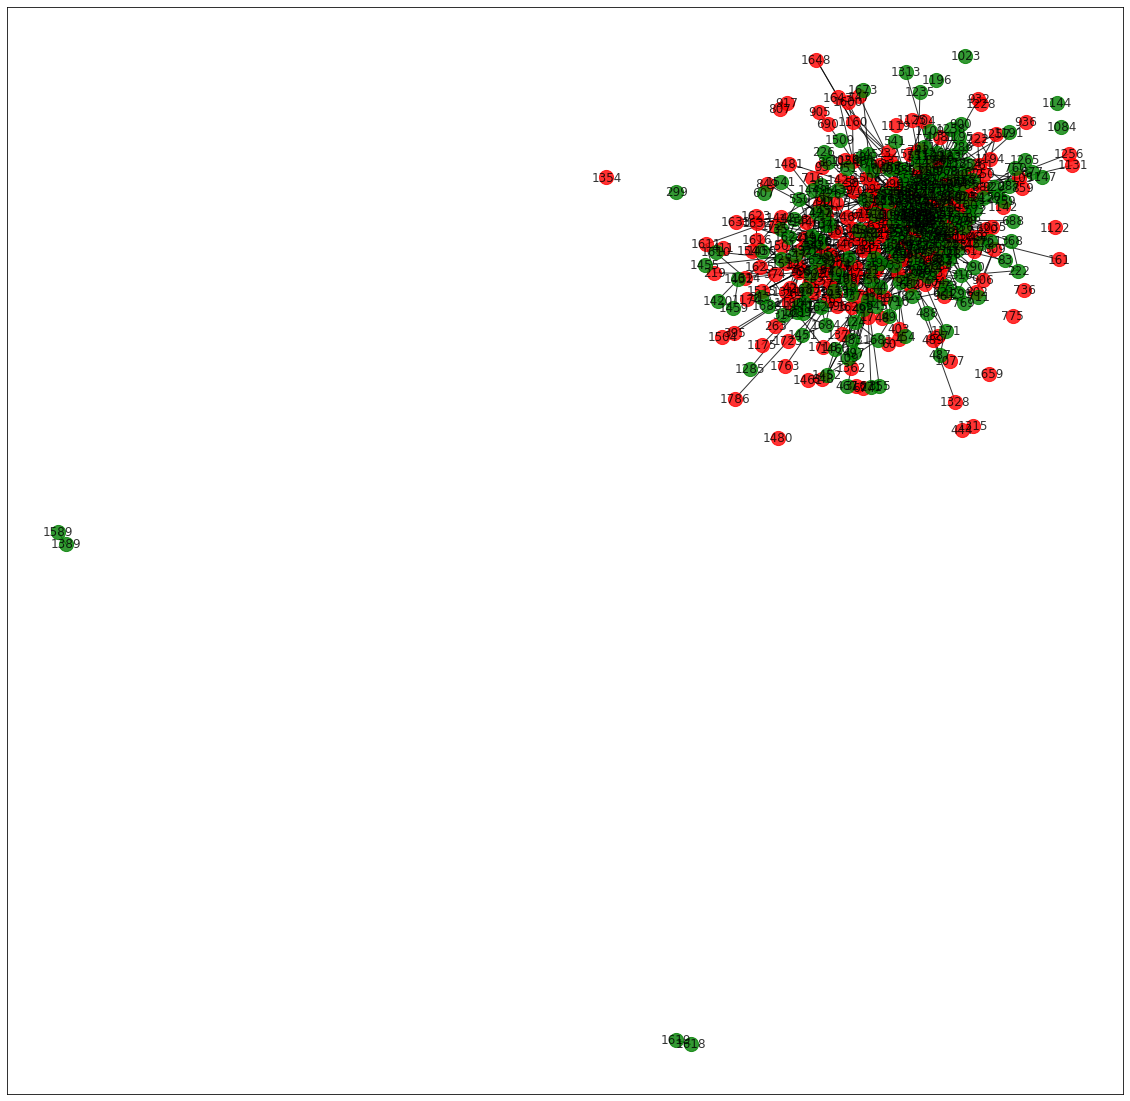

In [65]:
plt.figure(figsize = (20,20))
options = {"node_size": 200, "alpha": 0.8}

#pos = nx.spring_layout(orig_G, k = 0.01)
nx.draw_networkx(tmp1, pos, node_color='r', **options)
nx.draw_networkx(tmp2, pos, node_color='g', **options)

